# Instalación de Dependencias e Importación de Librerías
Instalación de PyWavelets, fCWT y otras dependencias necesarias. Importación de todas las bibliotecas requeridas para procesamiento de señales, visualización y aprendizaje profundo.

In [ ]:
# Instalación de dependencias necesarias
!pip install PyWavelets
!git clone https://github.com/fastlib/fCWT.git
!pip install fCWT
!apt-get update
!apt-get install libfftw3-single3 -y
!pip install opencv-python

# Importación de bibliotecas necesarias
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import random
import h5py
import cv2
import pywt
import fcwt
import scipy
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.notebook import tqdm
from IPython.display import display

# Importar la clase WaveletDenoising (debe estar en un archivo denoising.py en el path)
from denoising import WaveletDenoising

# Montar Google Drive (para Colab)
from google.colab import drive
drive.mount('/content/drive')

# Configuraciones globales para visualización
plt.style.use('seaborn-v0_8-whitegrid')

fatal: destination path 'fCWT' already exists and is not an empty directory.
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry miss

# Carga y Visualización de Datos
Carga de los datos de acelerómetro desde Google Drive, con opciones para clasificación binaria o multiclase. Visualización de las señales originales.

Data Directory: /content/drive/MyDrive/Tesis/Accelerometer_Dataset/Branched
Sample Rate: 25600 Hz
Classification Mode: five_classes
Number of signals (training, testing): (960, 240)
Number of labels (training, testing): (960, 240)
Number of samples per signal: 25600


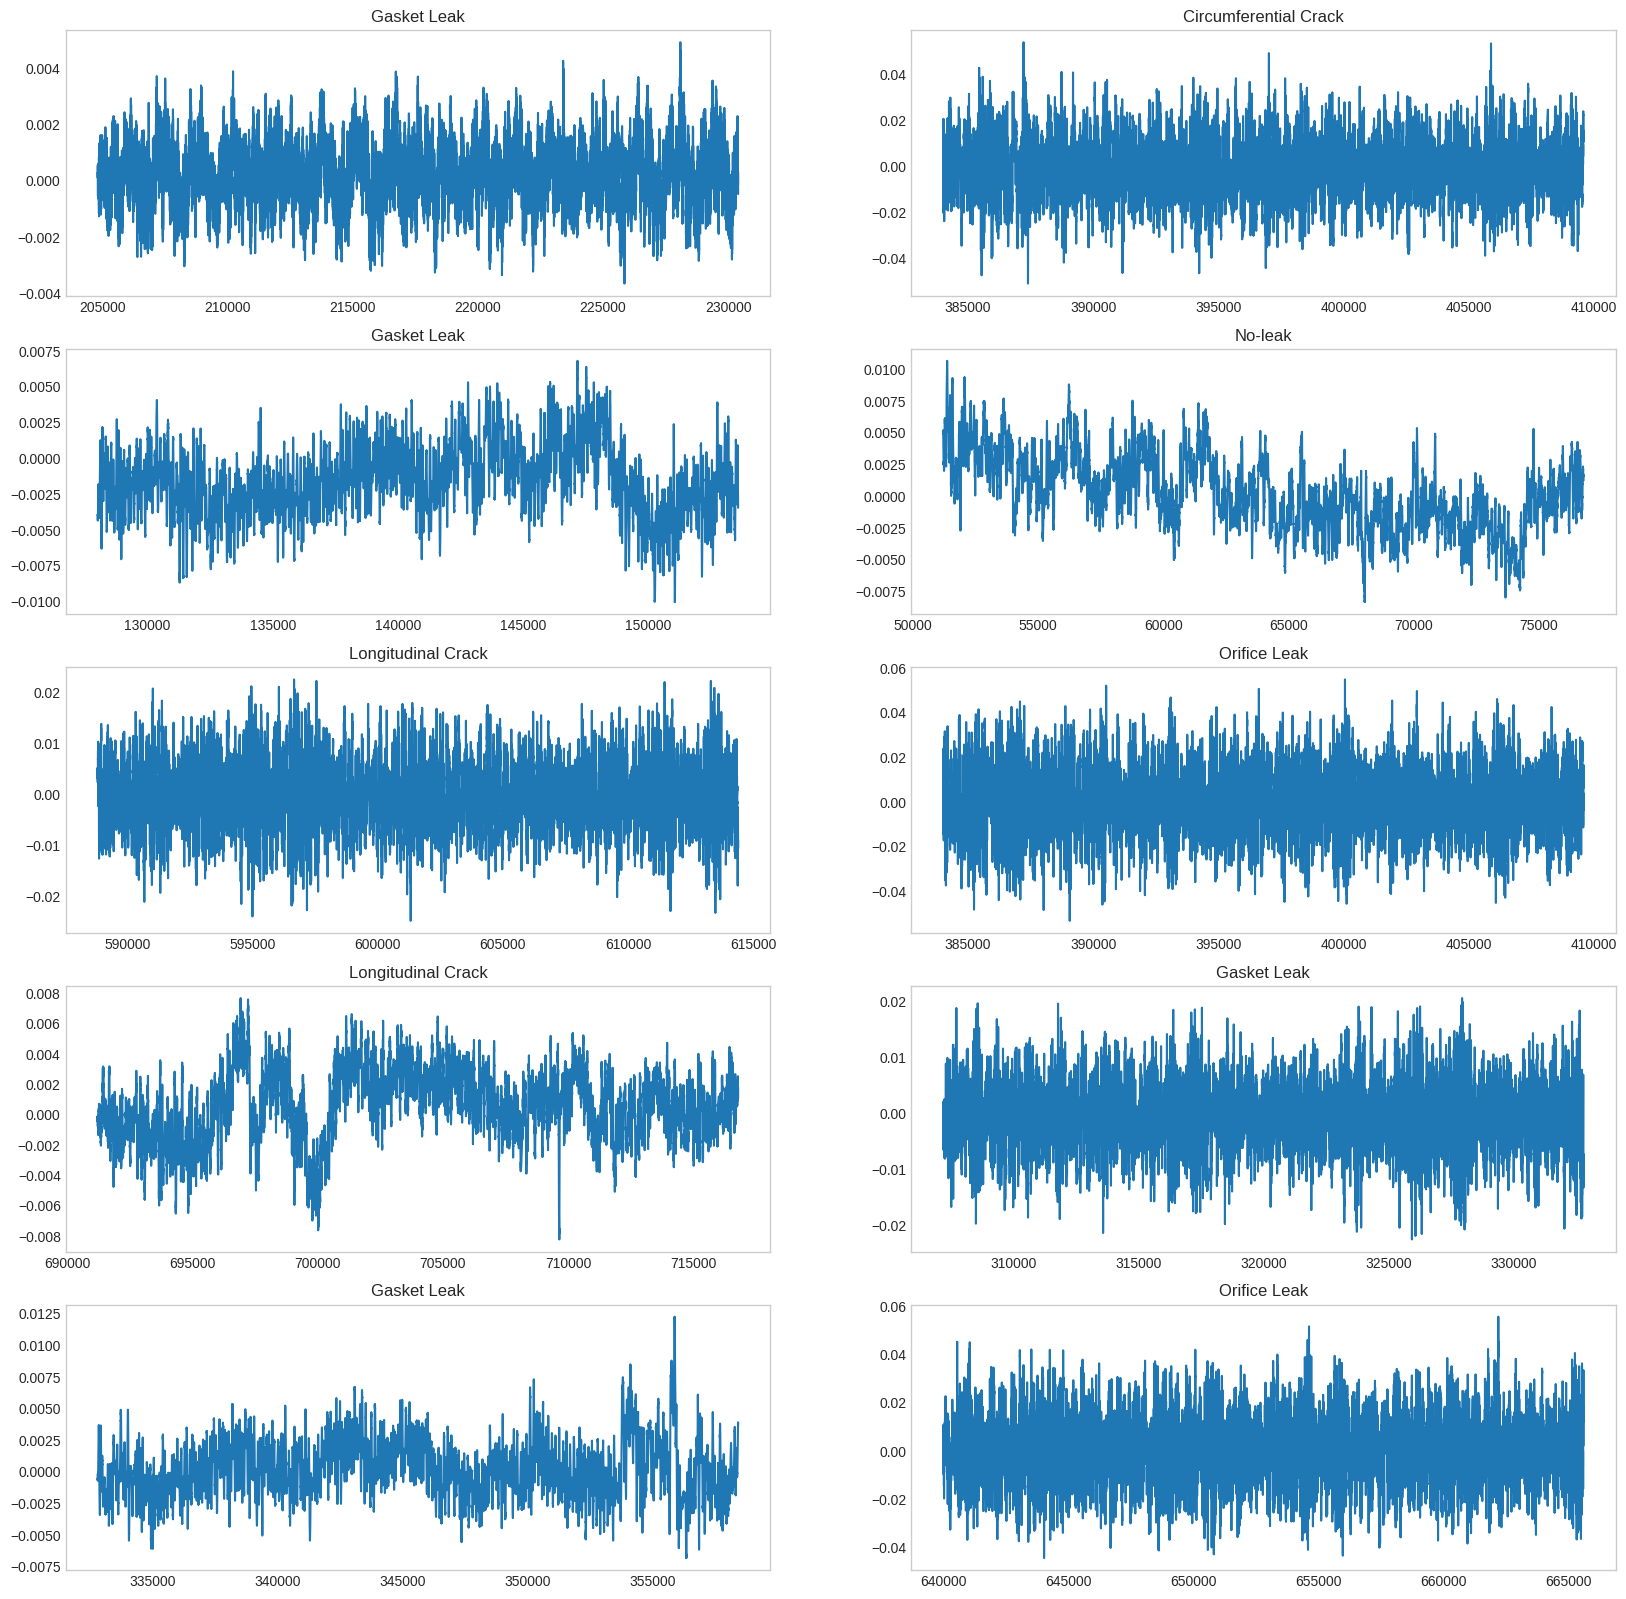

In [ ]:
# Definir la ruta de los datos en Google Drive
data_dir = '/content/drive/MyDrive/Tesis/Accelerometer_Dataset/Branched'
original_sr = 25600  # Frecuencia de muestreo original en Hz
signal_sr = 25600  # Frecuencia de muestreo deseada en Hz
downsample_factor = original_sr // signal_sr

# Modo de clasificación: 'five_classes' o 'binary'
classification_mode = 'five_classes'  # Cambiar según necesidad

# Diccionario de etiquetas según el modo de clasificación
if classification_mode == 'five_classes':
    label_codes_dict = {
        'Circumferential Crack': 0,
        'Gasket Leak': 1,
        'Longitudinal Crack': 2,
        'No-leak': 3,
        'Orifice Leak': 4
    }
else:  # binary
    label_codes_dict = {'Leak': 0, 'No-leak': 1}

# Función para eliminar archivos .DS_Store si existen
def remove_DS_store_file(path):
    for ds_name in ['.DS_Store', '.DS_store']:
        ds_store_file_location = os.path.join(path, ds_name)
        if os.path.isfile(ds_store_file_location):
            os.remove(ds_store_file_location)

# Función para cargar datos de acelerómetro
def load_accelerometer_data(data_dir, sample_rate, downsample_factor, label_codes, mode='five_classes', fraction_to_include=1):
    remove_DS_store_file(data_dir)
    signals = []
    labels = []

    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if not os.path.isdir(label_dir):
            print(f"Omitiendo {label_dir} porque no es un directorio")
            continue

        remove_DS_store_file(label_dir)

        for file in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file)
            if not os.path.isfile(file_path):
                continue

            accelerometer_signal_df = pd.read_csv(file_path, index_col=False)
            accelerometer_signal_df = accelerometer_signal_df.iloc[::downsample_factor, :].reset_index(drop=True)
            accelerometer_signal = accelerometer_signal_df['Value'][0:(sample_rate * 30)]

            sample_indexes = np.linspace(0, len(accelerometer_signal) - sample_rate, len(accelerometer_signal) // sample_rate)
            signal_frames_number = fraction_to_include * len(sample_indexes)
            signal_frames_counter = 0

            for signal_frame in sample_indexes:
                accelerometer_signal_frame = accelerometer_signal[int(signal_frame):int(signal_frame + sample_rate)]
                signal_frames_counter += 1

                if signal_frames_counter > signal_frames_number:
                    break

                if len(accelerometer_signal_frame) != sample_rate:
                    continue

                if mode == 'five_classes':
                    signals.append(accelerometer_signal_frame)
                    labels.append(label_codes[label])
                else:  # binary
                    if label == 'No-leak':
                        signals.append(accelerometer_signal_frame)
                        labels.append(1)  # 1 para No-leak
                    else:
                        signals.append(accelerometer_signal_frame)
                        labels.append(0)  # 0 para Leak

    return signals, labels

# Cargar los datos desde Google Drive
signals_lst, labels_lst = load_accelerometer_data(
    data_dir,
    signal_sr,
    downsample_factor,
    label_codes_dict,
    mode=classification_mode,
    fraction_to_include=1
)

# Dividir los datos en conjuntos de entrenamiento y prueba
signals_dict = {'training': [], 'testing': []}
labels_dict = {'training': [], 'testing': []}

signals_dict['training'], signals_dict['testing'], labels_dict['training'], labels_dict['testing'] = train_test_split(
    signals_lst,
    labels_lst,
    test_size=0.2,
    random_state=53
)

# Imprimir información sobre el dataset
print(f'Data Directory: {data_dir}')
print(f'Sample Rate: {signal_sr} Hz')
print(f'Classification Mode: {classification_mode}')
print(f'Number of signals (training, testing): ({len(signals_dict["training"])}, {len(signals_dict["testing"])})')
print(f'Number of labels (training, testing): ({len(labels_dict["training"])}, {len(labels_dict["testing"])})')
print(f'Number of samples per signal: {len(signals_dict["training"][0])}')

# Visualizar algunas señales
plt.figure(figsize=(20, 20))
rows, cols = 5, 2
n = rows * cols
random_index = []

for i in range(n):
    plt.subplot(rows, cols, i + 1)
    random_index.append(np.random.randint(0, len(signals_dict['training'])))
    plt.plot(signals_dict['training'][random_index[i]])

    if classification_mode == 'five_classes':
        label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(labels_dict['training'][random_index[i]])]
    else:
        label_name = 'Leak' if labels_dict['training'][random_index[i]] == 0 else 'No-leak'

    plt.title(label_name)
    plt.grid()
plt.show()

# Normalización y Denoising con Wavelet
Aplicación de técnicas de denoising basadas en wavelet para eliminar el ruido en las señales. Normalización posterior para preparar los datos para el cálculo de CWT.

Denoising training signals:   0%|          | 0/960 [00:00<?, ?it/s]

Denoising testing signals:   0%|          | 0/240 [00:00<?, ?it/s]

Number of signals (training, testing): (960, 240)
Number of labels (training, testing): (960, 240)
Number of samples per signal: 25600


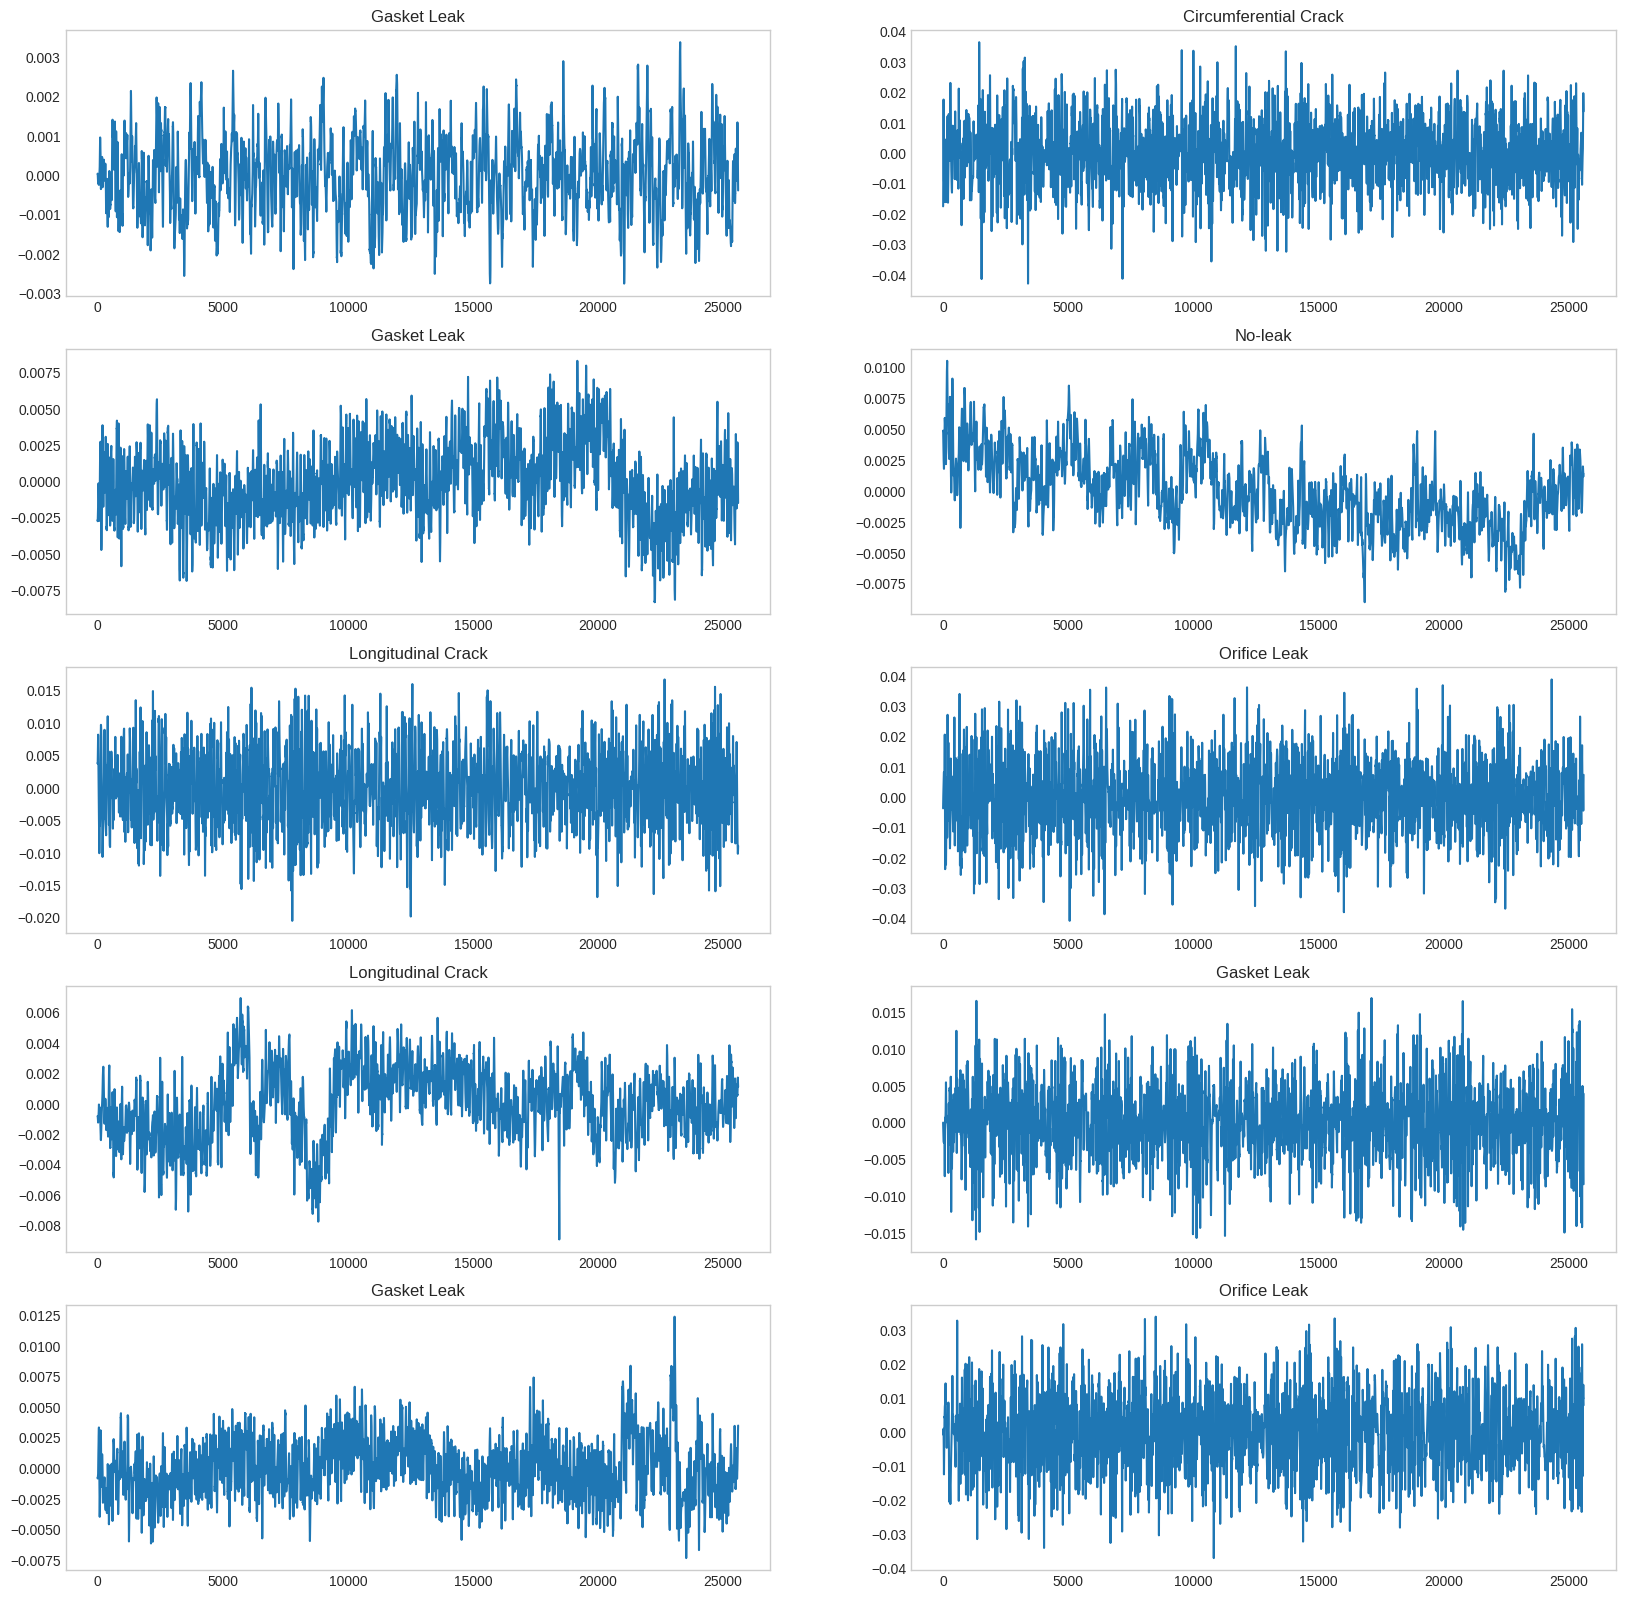

Normalizando señales procesadas con wavelet denoising...


Normalizando training signals:   0%|          | 0/960 [00:00<?, ?it/s]

Normalizando testing signals:   0%|          | 0/240 [00:00<?, ?it/s]

Number of signals (training, testing): (960, 240)
Number of samples per signal: 25600
Rango de valores en training: [0.0000, 1.0000]
Rango de valores en testing: [0.0000, 1.0000]


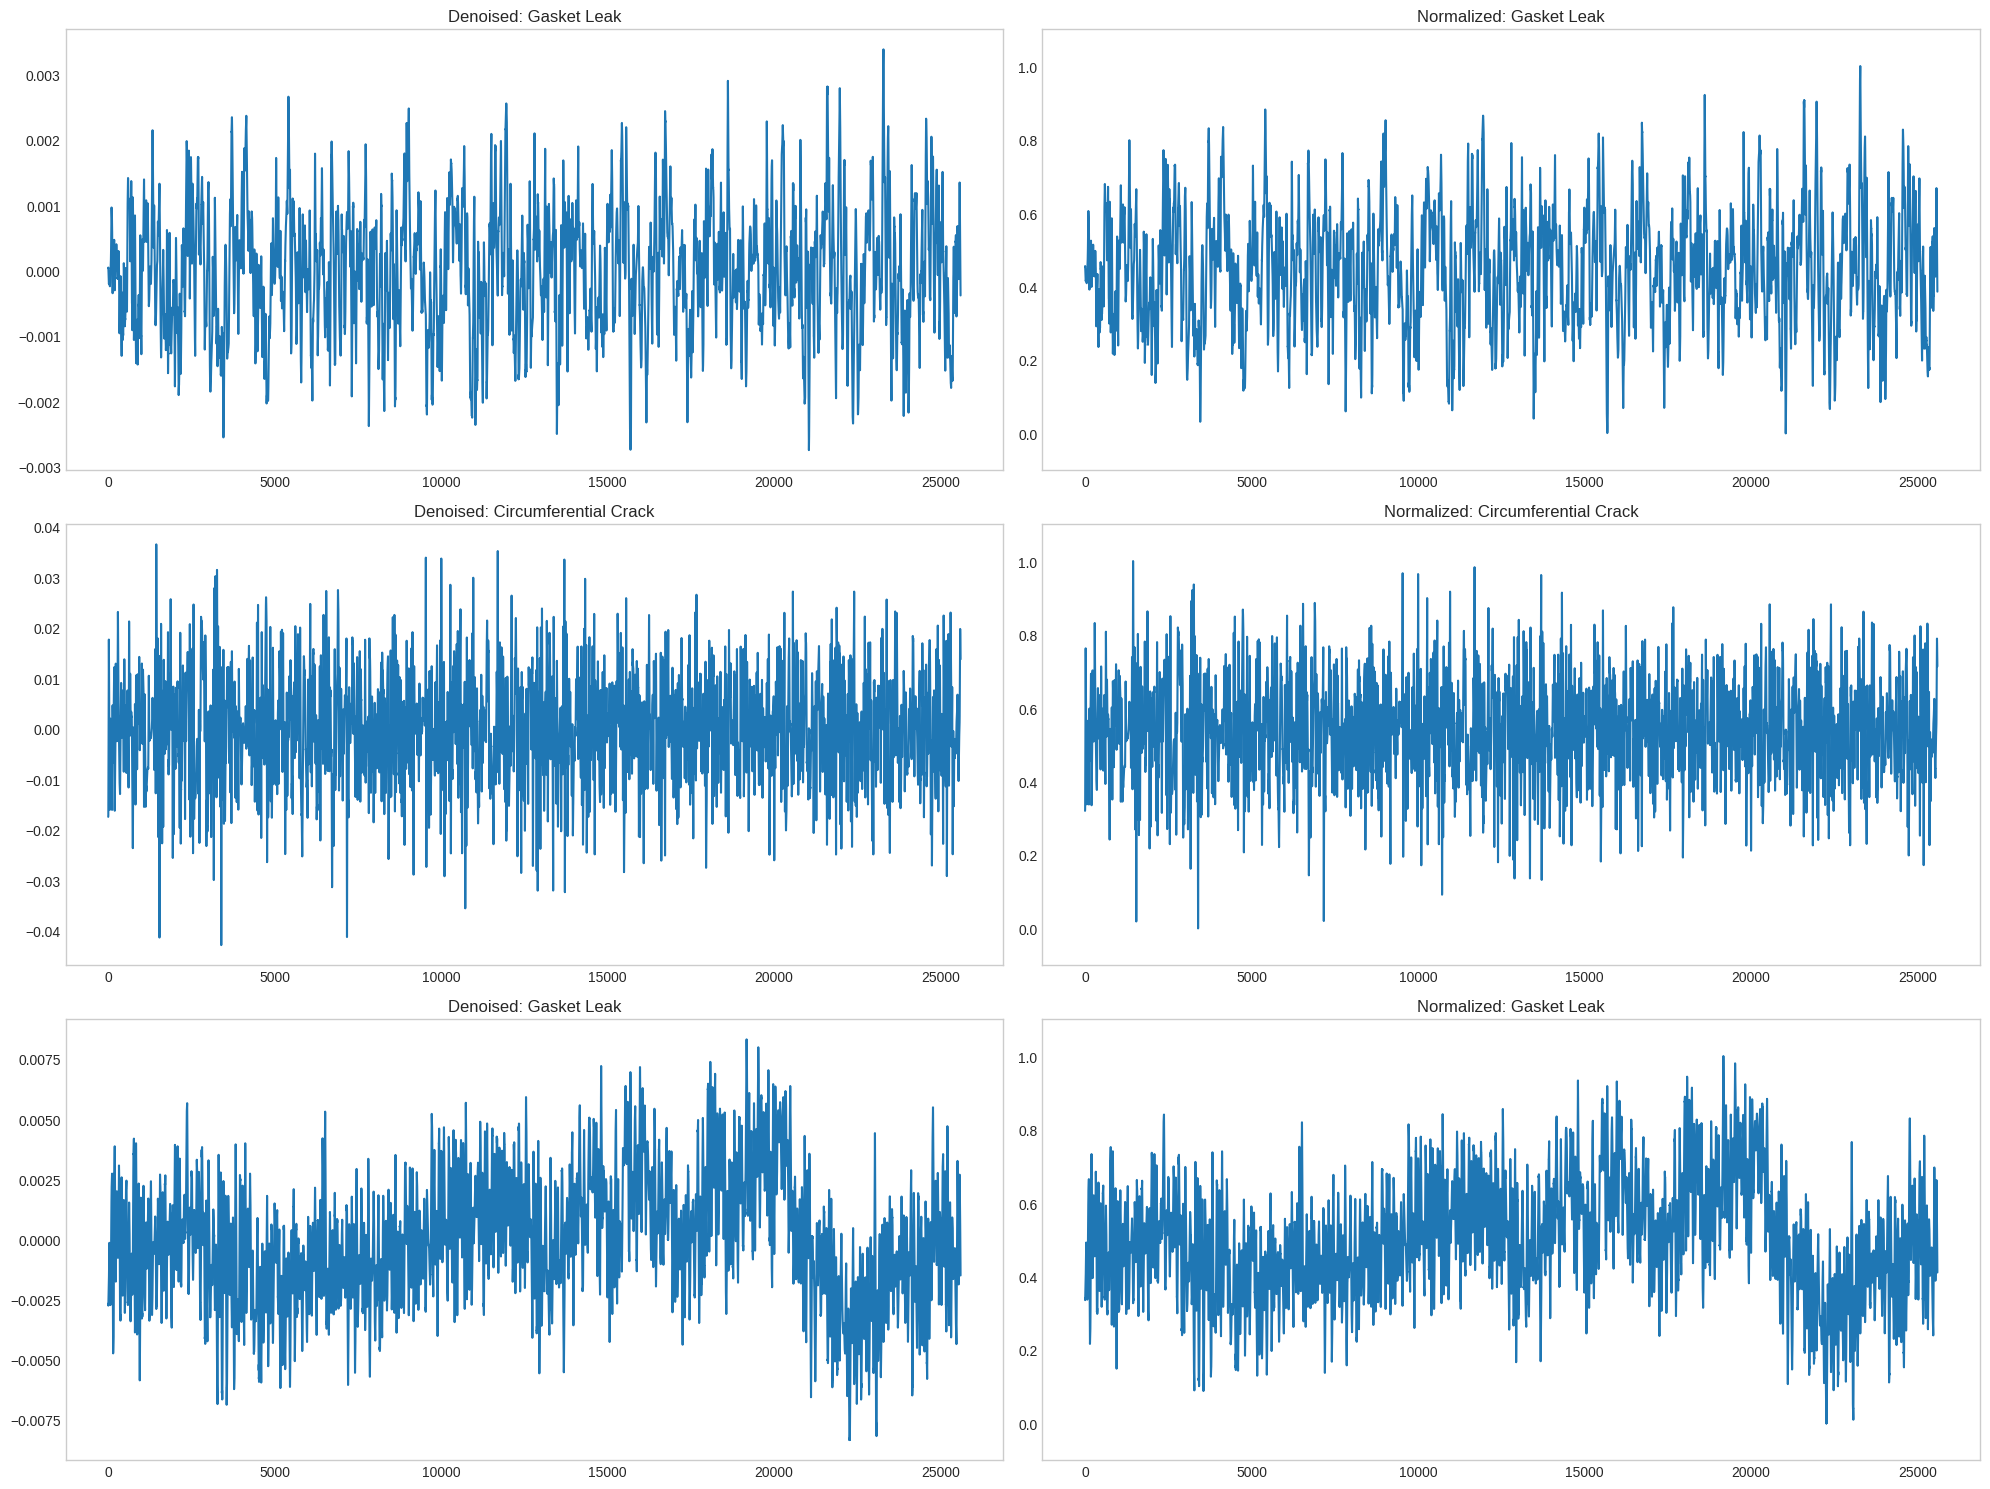

In [ ]:
# Función para aplicar denoising con wavelet
def wavelet_denoise(signals_dict, labels_dict):
    """
    Normaliza y aplica denoising wavelet a las señales.

    Args:
        signals_dict: Diccionario con señales de entrenamiento y prueba.
        labels_dict: Diccionario con etiquetas de entrenamiento y prueba.

    Returns:
        wavelet_denoised_signals: Diccionario con señales procesadas.
        labels_dict: Diccionario con etiquetas.
    """
    # Crear un objeto de la clase WaveletDenoising
    wd = WaveletDenoising(
        normalize=True,
        wavelet='sym3',
        level=4,
        thr_mode='soft',
        method="universal"
    )

    # Crear un nuevo diccionario para almacenar las señales procesadas
    wavelet_denoised_signals = {'training': [], 'testing': []}

    for key, signals_subset in signals_dict.items():
        for signal_element in tqdm(signals_subset, desc=f"Denoising {key} signals"):
            # Aplicar denoising a la señal
            denoised_signal = wd.fit(signal_element)
            wavelet_denoised_signals[key].append(denoised_signal)

    return wavelet_denoised_signals, labels_dict

# Aplicar denoising a las señales
wavelet_denoised_signals_dict, labels_dict = wavelet_denoise(signals_dict=signals_dict, labels_dict=labels_dict)

# Imprimir información sobre el dataset resultante
print(f'Number of signals (training, testing): ({len(wavelet_denoised_signals_dict["training"])}, {len(wavelet_denoised_signals_dict["testing"])})')
print(f'Number of labels (training, testing): ({len(labels_dict["training"])}, {len(labels_dict["testing"])})')
print(f'Number of samples per signal: {len(wavelet_denoised_signals_dict["training"][0])}')

# Visualizar algunas señales procesadas
plt.figure(figsize=(20, 20))
rows, cols = 5, 2
n = rows * cols

for i in range(n):
    plt.subplot(rows, cols, i + 1)
    plt.plot(wavelet_denoised_signals_dict['training'][random_index[i]])

    if classification_mode == 'five_classes':
        label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(labels_dict['training'][random_index[i]])]
    else:
        label_name = 'Leak' if labels_dict['training'][random_index[i]] == 0 else 'No-leak'

    plt.title(label_name)
    plt.grid()
plt.show()

# Función para normalizar señales
def normalize_signals(signals_dict):
    """
    Normaliza cada señal del diccionario a un rango de 0 a 1.

    Args:
        signals_dict: Diccionario con señales a normalizar.

    Returns:
        normalized_signals: Diccionario con señales normalizadas.
    """
    normalized_signals = {'training': [], 'testing': []}

    for key, signals_subset in signals_dict.items():
        for signal in tqdm(signals_subset, desc=f"Normalizando {key} signals"):
            min_val = np.min(signal)
            max_val = np.max(signal)

            if max_val > min_val:
                normalized_signal = (signal - min_val) / (max_val - min_val)
            else:
                normalized_signal = np.ones_like(signal) * 0.5

            normalized_signals[key].append(normalized_signal)

    return normalized_signals

# Normalizar las señales procesadas
print("Normalizando señales procesadas con wavelet denoising...")
normalized_signals_dict = normalize_signals(wavelet_denoised_signals_dict)

# Imprimir información sobre el dataset normalizado
print(f'Number of signals (training, testing): ({len(normalized_signals_dict["training"])}, {len(normalized_signals_dict["testing"])})')
print(f'Number of samples per signal: {len(normalized_signals_dict["training"][0])}')

# Comprobar rango de valores
for key in normalized_signals_dict:
    sample_signal = normalized_signals_dict[key][0]
    print(f"Rango de valores en {key}: [{np.min(sample_signal):.4f}, {np.max(sample_signal):.4f}]")

# Visualizar comparación de señales originales y normalizadas
plt.figure(figsize=(20, 15))
rows, cols = 3, 2
sample_indices = random_index[:3]

for i, idx in enumerate(sample_indices):
    # Señal con denoising (sin normalizar)
    plt.subplot(rows, cols, i * 2 + 1)
    plt.plot(wavelet_denoised_signals_dict['training'][idx])

    if classification_mode == 'five_classes':
        label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(labels_dict['training'][idx])]
    else:
        label_name = 'Leak' if labels_dict['training'][idx] == 0 else 'No-leak'

    plt.title(f"Denoised: {label_name}")
    plt.grid()

    # Señal normalizada entre 0 y 1
    plt.subplot(rows, cols, i * 2 + 2)
    plt.plot(normalized_signals_dict['training'][idx])
    plt.title(f"Normalized: {label_name}")
    plt.ylim([-0.1, 1.1])
    plt.grid()

plt.tight_layout()
plt.show()

# Usar las señales normalizadas para los pasos siguientes
wavelet_denoised_signals_dict = normalized_signals_dict

# Cálculo de Escalogramas CWT
Cálculo de la Transformada Wavelet Continua (CWT) utilizando la librería fCWT. Implementación del manejo del Cone of Influence (COI) para abordar los efectos de borde en los escalogramas.

In [ ]:
# Función para calcular la CWT con manejo del COI
def calculate_cwt_with_coi(signal, fs=25600, f0=1.0, f1=None, fn=64, sigma=6.0, fast=True, norm=True, scaling="log", nthreads=8):
    """
    Calcula la CWT de una señal utilizando la biblioteca fCWT con manejo del COI.
    """
    signal = np.array(signal, dtype=np.float32)

    if f1 is None:
        f1 = fs / 2

    morlet = fcwt.Morlet(sigma)

    if scaling.lower() == "log":
        scale_type = fcwt.FCWT_LOGSCALES
    else:
        scale_type = fcwt.FCWT_LINFREQS

    scales_obj = fcwt.Scales(morlet, scale_type, fs, f0, f1, fn)

    scales_array = np.zeros(fn, dtype=np.float32)
    freqs_array = np.zeros(fn, dtype=np.float32)

    scales_obj.getScales(scales_array)
    scales_obj.getFrequencies(freqs_array)

    fcwt_obj = fcwt.FCWT(morlet, nthreads, fast, norm)

    cwt_output = np.zeros((fn, len(signal)), dtype=np.complex64)

    fcwt_obj.cwt(signal, scales_obj, cwt_output)

    coi_mask = calculate_coi_mask(cwt_output, scales_array, len(signal), sigma)

    return freqs_array, cwt_output, coi_mask, scales_array

# Función para calcular la máscara del COI
def calculate_coi_mask(cwt_output, scales, signal_length, sigma=6.0):
    """
    Calcula la máscara del Cone of Influence (COI) para un escalograma CWT.
    """
    mask = np.ones_like(cwt_output, dtype=bool)

    for i in range(len(scales)):
        scale = scales[i]
        border_width = int(np.ceil(sigma * np.sqrt(2) * scale))
        border_width = min(border_width, signal_length // 2)

        if border_width > 0:
            mask[i, :border_width] = False
            mask[i, -border_width:] = False

    return mask

# Función para calcular escalogramas con manejo del COI
def get_cwt_features_with_coi(signals, labels, fs=25600, f0=1.0, f1=None, fn=64, sigma=6.0, nthreads=8, scaling="log", fast=True, norm=True, segment_size=512):
    """
    Calcula escalogramas CWT usando fCWT con aplicación de la máscara del COI.
    """
    if f1 is None:
        f1 = fs / 2

    scalograms = []
    scalograms_with_coi = []
    segment_labels = []
    coi_percentages = []

    for i, (signal, label) in enumerate(tqdm(zip(signals, labels), total=len(signals), desc="Calculando CWT con COI")):
        num_segments = len(signal) // segment_size

        for j in range(num_segments):
            segment = signal[j * segment_size:(j + 1) * segment_size]

            try:
                freqs, cwt_coef, coi_mask, scales = calculate_cwt_with_coi(segment, fs, f0, f1, fn, sigma, fast, norm, scaling, nthreads)

                valid_percentage = np.mean(coi_mask) * 100
                coi_percentages.append(valid_percentage)

                scalogram_full = np.square(np.abs(cwt_coef)).T

                scalogram_coi = scalogram_full.copy()
                scalogram_coi[coi_mask.T] = 0

                training_scalogram = np.nan_to_num(scalogram_coi, nan=0.0)

                scalograms.append(training_scalogram)
                scalograms_with_coi.append(scalogram_full)
                segment_labels.append(label)

            except Exception as e:
                print(f"Error en segmento {j} de señal {i}: {e}")
                continue

    return scalograms, segment_labels, coi_percentages, scalograms_with_coi

# Función para visualizar escalogramas
def plot_cwt_scalograms_comparison(scalograms_original, scalograms_coi, labels, label_codes_dict, num_per_class=2, fs=25600, segment_size=512, sigma=6.0):
    """
    Visualiza una comparación entre escalogramas originales y con COI aplicado.
    """
    t_duration = segment_size / fs
    f0 = 1.0
    f1 = fs / 2

    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    rows = num_classes
    cols = 2 * num_per_class

    plt.figure(figsize=(15, 4 * rows))

    for i, label_code in enumerate(unique_labels):
        class_indices = [idx for idx, l in enumerate(labels) if l == label_code]

        if len(class_indices) == 0:
            continue

        selected_indices = random.sample(class_indices, min(num_per_class, len(class_indices)))

        for j, idx in enumerate(selected_indices):
            if 'classification_mode' in globals() and globals()['classification_mode'] == 'five_classes':
                label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(label_code)]
            else:
                label_name = 'Leak' if label_code == 0 else 'No-leak'

            ax = plt.subplot(rows, cols, i * cols + j * 2 + 1)
            im = ax.imshow(scalograms_original[idx], aspect='auto', origin='lower', extent=[0, t_duration, f0, f1], cmap=cm.viridis)
            ax.set_yscale('log')
            ax.set_title(f"Original: {label_name}")
            ax.set_xlabel('Tiempo (s)')
            ax.set_ylabel('Frecuencia (Hz)')
            plt.colorbar(im, ax=ax, label='Energía')

            ax = plt.subplot(rows, cols, i * cols + j * 2 + 2)
            im = ax.imshow(scalograms_coi[idx], aspect='auto', origin='lower', extent=[0, t_duration, f0, f1], cmap=cm.viridis)
            ax.set_yscale('log')
            ax.set_title(f"COI aplicado: {label_name} (σ={sigma})")
            ax.set_xlabel('Tiempo (s)')
            ax.set_ylabel('Frecuencia (Hz)')
            plt.colorbar(im, ax=ax, label='Energía')

    plt.tight_layout()
    plt.show()

# Calcular escalogramas con manejo del COI
train_scalograms, train_labels, train_coi_percentages, train_scalograms_full = get_cwt_features_with_coi(
    wavelet_denoised_signals_dict['training'],
    labels_dict['training'],
    segment_size=512,
    fn=10,
    sigma=6.0,
    scaling="log",
    nthreads=1
)

test_scalograms, test_labels, test_coi_percentages, test_scalograms_full = get_cwt_features_with_coi(
    wavelet_denoised_signals_dict['testing'],
    labels_dict['testing'],
    segment_size=512,
    fn=10,
    sigma=6.0,
    scaling="log",
    nthreads=1
)

# Visualizar comparación de escalogramas
plot_cwt_scalograms_comparison(
    train_scalograms_full,
    train_scalograms,
    train_labels,
    label_codes_dict,
    num_per_class=2
)

Calculando CWT con COI:   0%|          | 0/960 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Procesamiento de Escalogramas - Creación de ELIS
Implementación de la técnica Enhanced Log-scaled Intensity Scalogram (ELIS) para mejorar la visualización y representación de los escalogramas CWT, aplicando realce adaptativo de características.

In [ ]:
# Función para crear ELIS (Enhanced Log-scaled Intensity Scalogram)
def create_elis(scalograms, alpha=0.5, beta=0.5):
    """
    Aplica la técnica ELIS a una lista de escalogramas.

    Args:
        scalograms: Lista de escalogramas originales.
        alpha: Parámetro de realce adaptativo.
        beta: Parámetro de ajuste de intensidad.

    Returns:
        Lista de escalogramas ELIS.
    """
    elis_scalograms = []

    for scalogram in tqdm(scalograms, desc="Creando ELIS"):
        # Aplicar logaritmo para escalar la intensidad
        log_scaled = np.log1p(scalogram)

        # Realce adaptativo
        enhanced = alpha * log_scaled + beta * np.sqrt(log_scaled)

        # Normalizar entre 0 y 1
        min_val = np.min(enhanced)
        max_val = np.max(enhanced)
        if max_val > min_val:
            normalized = (enhanced - min_val) / (max_val - min_val)
        else:
            normalized = np.zeros_like(enhanced)

        elis_scalograms.append(normalized)

    return elis_scalograms

# Aplicar ELIS a los escalogramas de entrenamiento y prueba
train_elis_scalograms = create_elis(train_scalograms)
test_elis_scalograms = create_elis(test_scalograms)

# Visualizar algunos escalogramas ELIS
def plot_elis_scalograms(elis_scalograms, labels, label_codes_dict, num_per_class=2, fs=25600, segment_size=512):
    """
    Visualiza escalogramas ELIS.

    Args:
        elis_scalograms: Lista de escalogramas ELIS.
        labels: Lista de etiquetas correspondientes.
        label_codes_dict: Diccionario de códigos de etiquetas.
        num_per_class: Número de escalogramas a mostrar por clase.
        fs: Frecuencia de muestreo (Hz).
        segment_size: Tamaño del segmento en muestras.
    """
    t_duration = segment_size / fs
    f0 = 1.0
    f1 = fs / 2

    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    rows = num_classes
    cols = num_per_class

    plt.figure(figsize=(15, 4 * rows))

    for i, label_code in enumerate(unique_labels):
        class_indices = [idx for idx, l in enumerate(labels) if l == label_code]

        if len(class_indices) == 0:
            continue

        selected_indices = random.sample(class_indices, min(num_per_class, len(class_indices)))

        for j, idx in enumerate(selected_indices):
            if 'classification_mode' in globals() and globals()['classification_mode'] == 'five_classes':
                label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(label_code)]
            else:
                label_name = 'Leak' if label_code == 0 else 'No-leak'

            ax = plt.subplot(rows, cols, i * cols + j + 1)
            im = ax.imshow(elis_scalograms[idx], aspect='auto', origin='lower', extent=[0, t_duration, f0, f1], cmap=cm.viridis)
            ax.set_yscale('log')
            ax.set_title(f"ELIS: {label_name}")
            ax.set_xlabel('Tiempo (s)')
            ax.set_ylabel('Frecuencia (Hz)')
            plt.colorbar(im, ax=ax, label='Energía')

    plt.tight_layout()
    plt.show()

# Visualizar escalogramas ELIS
plot_elis_scalograms(train_elis_scalograms, train_labels, label_codes_dict, num_per_class=2)

# Guardar y Cargar Datasets
Funciones para guardar los escalogramas procesados en formato HDF5 en Google Drive y cargarlos posteriormente. División de datos en conjuntos de entrenamiento, validación y prueba.

In [ ]:
# Función para guardar datasets procesados en formato HDF5
def save_elis_dataset(file_path, x_train, y_train, x_test, y_test, classification_mode, label_codes_dict=None):
    """
    Guarda el dataset de escalogramas ELIS procesados en formato HDF5.

    Args:
        file_path: Ruta del archivo HDF5 donde se guardará el dataset.
        x_train: Escalogramas ELIS de entrenamiento.
        y_train: Etiquetas de entrenamiento.
        x_test: Escalogramas ELIS de prueba.
        y_test: Etiquetas de prueba.
        classification_mode: Modo de clasificación ('five_classes' o 'binary').
        label_codes_dict: Diccionario de códigos de etiquetas (opcional).
    """
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    # Determinar número de clases
    num_classes = 5 if classification_mode == 'five_classes' else 2

    # Dividir conjunto de entrenamiento para crear un conjunto de validación
    val_split = 0.2
    val_indices = np.random.choice(len(x_train), int(len(x_train) * val_split), replace=False)
    train_mask = np.ones(len(x_train), dtype=bool)
    train_mask[val_indices] = False

    x_val = np.array(x_train)[~train_mask]
    y_val = np.array(y_train)[~train_mask]
    x_train = np.array(x_train)[train_mask]
    y_train = np.array(y_train)[train_mask]

    # Convertir etiquetas a one-hot
    y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
    y_val_onehot = keras.utils.to_categorical(y_val, num_classes)
    y_test_onehot = keras.utils.to_categorical(y_test, num_classes)

    # Guardar en formato HDF5
    with h5py.File(file_path, 'w') as hf:
        train_group = hf.create_group('train')
        val_group = hf.create_group('val')
        test_group = hf.create_group('test')
        metadata_group = hf.create_group('metadata')

        train_group.create_dataset('x_train', data=x_train)
        train_group.create_dataset('y_train', data=y_train)
        train_group.create_dataset('y_train_onehot', data=y_train_onehot)

        val_group.create_dataset('x_val', data=x_val)
        val_group.create_dataset('y_val', data=y_val)
        val_group.create_dataset('y_val_onehot', data=y_val_onehot)

        test_group.create_dataset('x_test', data=x_test)
        test_group.create_dataset('y_test', data=y_test)
        test_group.create_dataset('y_test_onehot', data=y_test_onehot)

        metadata_group.attrs['num_classes'] = num_classes
        metadata_group.attrs['classification_mode'] = classification_mode

    # Guardar diccionario de etiquetas en un archivo de texto
    if label_codes_dict is not None:
        classes_file = file_path.replace('.h5', '_classes.txt')
        with open(classes_file, 'w') as f:
            for name, code in label_codes_dict.items():
                f.write(f"{name}: {code}\n")

    print(f"Dataset guardado en: {file_path}")

# Guardar el dataset ELIS en Google Drive
elis_dataset_path = '/content/drive/MyDrive/Tesis/ELIS_Dataset/preCWT_segmented_elis_dataset.h5'
#save_elis_dataset(elis_dataset_path, train_elis_scalograms, train_labels, test_elis_scalograms, test_labels, classification_mode, label_codes_dict)

# Función para cargar datasets procesados desde formato HDF5
def load_elis_dataset(file_path):
    """
    Carga un dataset de escalogramas ELIS desde un archivo HDF5.

    Args:
        file_path: Ruta del archivo HDF5.

    Returns:
        Diccionario con los datos de entrenamiento, validación y prueba.
    """
    with h5py.File(file_path, 'r') as hf:
        x_train = np.array(hf['train']['x_train'])
        y_train = np.array(hf['train']['y_train'])
        y_train_onehot = np.array(hf['train']['y_train_onehot'])

        x_val = np.array(hf['val']['x_val'])
        y_val = np.array(hf['val']['y_val'])
        y_val_onehot = np.array(hf['val']['y_val_onehot'])

        x_test = np.array(hf['test']['x_test'])
        y_test = np.array(hf['test']['y_test'])
        y_test_onehot = np.array(hf['test']['y_test_onehot'])

        num_classes = hf['metadata'].attrs['num_classes']
        classification_mode = hf['metadata'].attrs['classification_mode']

    print(f"Dataset cargado desde: {file_path}")
    print(f"- Número de clases: {num_classes}")
    print(f"- Modo de clasificación: {classification_mode}")
    print(f"- Muestras de entrenamiento: {len(x_train)}")
    print(f"- Muestras de validación: {len(x_val)}")
    print(f"- Muestras de prueba: {len(x_test)}")

    return {
        'x_train': x_train,
        'y_train': y_train,
        'y_train_onehot': y_train_onehot,
        'x_val': x_val,
        'y_val': y_val,
        'y_val_onehot': y_val_onehot,
        'x_test': x_test,
        'y_test': y_test,
        'y_test_onehot': y_test_onehot
    }

# Cargar el dataset ELIS desde Google Drive
elis_dataset = load_elis_dataset(elis_dataset_path)

Dataset cargado desde: /content/drive/MyDrive/Tesis/ELIS_Dataset/elis_dataset.h5
- Número de clases: 5
- Modo de clasificación: five_classes
- Muestras de entrenamiento: 38400
- Muestras de validación: 9600
- Muestras de prueba: 12000


# Implementación del Modelo ResNet-18
Implementación de una arquitectura ResNet-18 adaptada para clasificación de escalogramas, con técnicas de regularización como dropout y regularización L2 para prevenir el sobreajuste.

In [ ]:
# Implementación del modelo ResNet-18 adaptado para clasificación de escalogramas ELIS
def build_resnet18(input_shape, num_classes):
    """
    Construye un modelo ResNet-18 adaptado para clasificación de escalogramas.

    Args:
        input_shape: Forma de entrada de los datos (altura, ancho, canales).
        num_classes: Número de clases para la clasificación.

    Returns:
        Modelo ResNet-18 compilado.
    """
    inputs = keras.Input(shape=input_shape)

    # Primera capa de convolución
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding="same", kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    # Bloques residuales
    def residual_block(x, filters, downsample=False):
        identity = x
        stride = (2, 2) if downsample else (1, 1)

        x = layers.Conv2D(filters, (3, 3), strides=stride, padding="same", kernel_regularizer=regularizers.l2(1e-4))(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, (3, 3), strides=(1, 1), padding="same", kernel_regularizer=regularizers.l2(1e-4))(x)
        x = layers.BatchNormalization()(x)

        if downsample:
            identity = layers.Conv2D(filters, (1, 1), strides=stride, padding="same", kernel_regularizer=regularizers.l2(1e-4))(identity)
            identity = layers.BatchNormalization()(identity)

        x = layers.add([x, identity])
        x = layers.ReLU()(x)
        return x

    # Construcción de bloques residuales
    for filters, blocks, downsample in zip([64, 128, 256, 512], [2, 2, 2, 2], [False, True, True, True]):
        for _ in range(blocks):
            x = residual_block(x, filters, downsample)
            downsample = False  # Solo el primer bloque de cada etapa realiza downsampling

    # Capa final
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Dropout para regularización
    outputs = layers.Dense(num_classes, activation="softmax", kernel_regularizer=regularizers.l2(1e-4))(x)

    model = keras.Model(inputs, outputs)
    return model

# Cargar los datos del dataset ELIS
x_train, y_train = elis_dataset['x_train'], elis_dataset['y_train_onehot']
x_val, y_val = elis_dataset['x_val'], elis_dataset['y_val_onehot']
x_test, y_test = elis_dataset['x_test'], elis_dataset['y_test_onehot']

# Añadir dimensión de canal a los datos
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

# Verificar la nueva forma
print(f"Forma de los datos después de añadir el canal: {x_train.shape}")

# Construir el modelo ResNet-18
input_shape = x_train.shape[1:]  # Forma de entrada de los datos
num_classes = y_train.shape[1]  # Número de clases
resnet18_model = build_resnet18(input_shape, num_classes)

# Compilar el modelo
resnet18_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
# Definir warmup_schedule para la tasa de aprendizaje
def warmup_schedule(epoch, lr):
    warmup_epochs = 5
    init_lr = 1e-6
    target_lr = 0.0005

    if epoch < warmup_epochs:
        return init_lr + (target_lr - init_lr) * epoch / warmup_epochs
    return lr

keras.callbacks.LearningRateScheduler(warmup_schedule),
# Configurar callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
    keras.callbacks.LearningRateScheduler(warmup_schedule),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=8, min_lr=1e-6),
    ModelCheckpoint(filepath="/content/drive/MyDrive/Tesis/ELIS_Dataset/resnet18_best_model.h5", save_best_only=True, monitor="val_loss")
]

# Entrenar el modelo
history = resnet18_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=callbacks
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = resnet18_model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Visualizar las métricas de entrenamiento
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Generar reporte de clasificación
y_pred = np.argmax(resnet18_model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(label_codes_dict.keys())))

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(label_codes_dict.keys()), yticklabels=list(label_codes_dict.keys()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Forma de los datos después de añadir el canal: (38400, 512, 10, 1)
Epoch 1/200


KeyboardInterrupt: 

Aplicando data augmentation a los datos de entrenamiento...
Forma original de datos: (38400, 512, 10, 1)
Aplicando data augmentation de manera eficiente en memoria


Procesando por lotes:   0%|          | 0/600 [00:00<?, ?it/s]

In [ ]:
# Importaciones necesarias para data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Implementación del modelo ResNet-18 adaptado para clasificación de escalogramas ELIS
def build_resnet18(input_shape, num_classes):
    """
    Construye un modelo ResNet-18 adaptado para clasificación de escalogramas.

    Args:
        input_shape: Forma de entrada de los datos (altura, ancho, canales).
        num_classes: Número de clases para la clasificación.

    Returns:
        Modelo ResNet-18 compilado.
    """
    inputs = keras.Input(shape=input_shape)

    # Primera capa de convolución
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding="same", kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    # Bloques residuales
    def residual_block(x, filters, downsample=False):
        identity = x
        stride = (2, 2) if downsample else (1, 1)

        x = layers.Conv2D(filters, (3, 3), strides=stride, padding="same", kernel_regularizer=regularizers.l2(1e-4))(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, (3, 3), strides=(1, 1), padding="same", kernel_regularizer=regularizers.l2(1e-4))(x)
        x = layers.BatchNormalization()(x)

        if downsample:
            identity = layers.Conv2D(filters, (1, 1), strides=stride, padding="same", kernel_regularizer=regularizers.l2(1e-4))(identity)
            identity = layers.BatchNormalization()(identity)

        x = layers.add([x, identity])
        x = layers.ReLU()(x)
        return x

    # Construcción de bloques residuales
    for filters, blocks, downsample in zip([64, 128, 256, 512], [2, 2, 2, 2], [False, True, True, True]):
        for _ in range(blocks):
            x = residual_block(x, filters, downsample)
            downsample = False  # Solo el primer bloque de cada etapa realiza downsampling

    # Capa final
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Dropout para regularización
    outputs = layers.Dense(num_classes, activation="softmax", kernel_regularizer=regularizers.l2(1e-4))(x)

    model = keras.Model(inputs, outputs)
    return model

# Cargar los datos del dataset ELIS
x_train, y_train = elis_dataset['x_train'], elis_dataset['y_train_onehot']
x_val, y_val = elis_dataset['x_val'], elis_dataset['y_val_onehot']
x_test, y_test = elis_dataset['x_test'], elis_dataset['y_test_onehot']

# Añadir dimensión de canal a los datos
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

# Verificar la nueva forma
print(f"Forma de los datos después de añadir el canal: {x_train.shape}")

# Construir el modelo ResNet-18
input_shape = x_train.shape[1:]  # Forma de entrada de los datos
num_classes = y_train.shape[1]  # Número de clases
resnet18_model = build_resnet18(input_shape, num_classes)

# Compilar el modelo
resnet18_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Definir warmup_schedule para la tasa de aprendizaje
def warmup_schedule(epoch, lr):
    warmup_epochs = 5
    init_lr = 1e-6
    target_lr = 0.0005

    if epoch < warmup_epochs:
        return init_lr + (target_lr - init_lr) * epoch / warmup_epochs
    return lr

# Configurar callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
    keras.callbacks.LearningRateScheduler(warmup_schedule),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=8, min_lr=1e-6),
    ModelCheckpoint(filepath="/content/drive/MyDrive/Tesis/ELIS_Dataset/resnet18_best_model.h5", save_best_only=True, monitor="val_loss")
]

# ===== CONFIGURACIÓN DE DATA AUGMENTATION CON IMAGEDATAGENERATOR =====
# Configurar el generador para los datos de entrenamiento
datagen = ImageDataGenerator(
    rotation_range=10,           # Rotación aleatoria en grados
    width_shift_range=0.1,       # Desplazamiento horizontal (simula variaciones de tiempo)
    height_shift_range=0.1,      # Desplazamiento vertical (simula variaciones de frecuencia)
    zoom_range=0.1,              # Zoom aleatorio
    horizontal_flip=False,       # No volteamos horizontalmente para preservar características temporales
    fill_mode='nearest',         # Método para rellenar píxeles nuevos
    preprocessing_function=lambda img: np.clip(img + np.random.normal(0, 0.03, img.shape), 0, 1)  # Ruido gaussiano
)

# Visualizar ejemplos de data augmentation
def visualize_augmentation(x_sample, y_sample, datagen, num_examples=3):
    """Visualiza ejemplos de data augmentation aplicados a los datos"""
    plt.figure(figsize=(15, 10))
    
    # Tomar algunas muestras para visualización
    samples_to_show = min(3, len(x_sample))
    
    for i in range(samples_to_show):
        # Muestra original
        plt.subplot(samples_to_show, 4, i*4 + 1)
        plt.imshow(x_sample[i].reshape(x_sample.shape[1], x_sample.shape[2]), 
                  aspect='auto', cmap='viridis')
        plt.title(f"Original {i+1}")
        plt.colorbar()
        
        # Muestras aumentadas (generamos 3 variaciones)
        sample = x_sample[i:i+1]  # Necesitamos mantener la dimensión de batch
        aug_iter = datagen.flow(sample, batch_size=1)
        
        for j in range(3):
            plt.subplot(samples_to_show, 4, i*4 + j + 2)
            aug_sample = next(aug_iter)[0]
            plt.imshow(aug_sample.reshape(x_sample.shape[1], x_sample.shape[2]),
                      aspect='auto', cmap='viridis')
            plt.title(f"Aumentada {j+1}")
            plt.colorbar()
    
    plt.tight_layout()
    plt.show()

# Visualizar algunas muestras con data augmentation
print("Visualizando ejemplos de data augmentation...")
visualize_augmentation(x_train, y_train, datagen, num_examples=3)

# ===== ENTRENAMIENTO DEL MODELO CON DATA AUGMENTATION =====
# Preparar el generador de datos aumentados
train_generator = datagen.flow(x_train, y_train, batch_size=32)

# Entrenar el modelo con data augmentation dinámico
print("Entrenando modelo con data augmentation...")
history = resnet18_model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=callbacks,
    verbose=1
)

# ===== EVALUACIÓN Y VISUALIZACIÓN =====
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = resnet18_model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Visualizar las métricas de entrenamiento
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Generar reporte de clasificación
y_pred = np.argmax(resnet18_model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(label_codes_dict.keys())))

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(label_codes_dict.keys()), yticklabels=list(label_codes_dict.keys()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()